# **AM 207**: Lab 5

### A puzzling pattern in a map

From Example 2.7 in Bayesian Data Analysis, also known as BDA, 3rd ed, Gelman et al, pages 47-51.  Data and slides available at http://www.stat.columbia.edu/~gelman/book/, see lecture 2b, slides 12-20.  First step is to load data into iPython notebook:

In [1]:
#Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

import seaborn as sns
sns.set_style("white")

import time

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

In [2]:
#Read in two text files, combine into one dataframe with all data from 1980-1989
#Be sure formatting of column headers is right; needed to adjust tabs
table_data = pd.read_table('gd80to84.txt')
table_data_2 = pd.read_table('gd85to89.txt')

new_df = pd.DataFrame(table_data['state'])
new_df['county'] = table_data['county']
#These are age adjusted kidney cancer death rates for counties in the U.S.
new_df['aadc'] = ( table_data['aadc'] + table_data_2['aadc'] ) / 2
new_df.head()

,state,county,aadc
0,ALABAMA,AUTAUGA,2.50
1,ALABAMA,BALDWIN,4.90
2,ALABAMA,BARBOUR,1.30
3,ALABAMA,BIBB,1.45
4,ALABAMA,BLOUNT,4.00


The motivation for this problem is that, as we have seen, the raw rates for counties with small populations are likely to be poor estimators of the actual likelihood of someone in that county dying from kidney cancer.  This is because small counties are likely to have zero such cases, meaning the raw rate is zero, or one such case, which gives the county a rate in the top 10% of U.S. counties and is probably unrealistic.  In order to get an intuition for the values of raw rates across the country, we can plot the histogram:

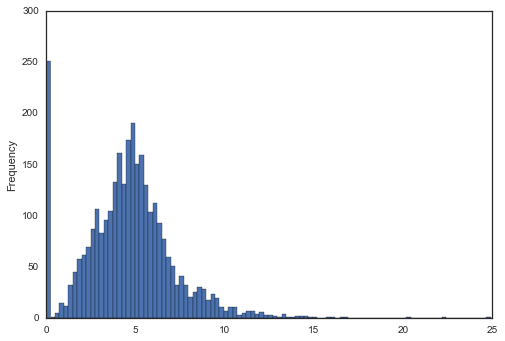

In [3]:
#Plot rates, similar to Figure 2.10
new_df['aadc'].plot(kind='hist', bins=100)

### Poisson likelihood with Gamma prior
For the likelihood function, we will model the deaths as Poisson events, according to these rates.  So we are motivated to use the Gamma distribution as the prior distribution for rates, because it is a conjugate prior for the Poisson.  This means we can check our results against analytical solutions, which is not usually the case, but is good to be able to do while learning.

The parameters used here for the Gamma distribution come from analytical solutions in Gelman, and are calculated using the mean and variance of the data for all counties in the U.S.  We will use this as our prior distribution for the Poisson rate parameter.  This is a quick way to obtain more realistic results, and it paves the way to begin thinking about hierarchical Bayes.

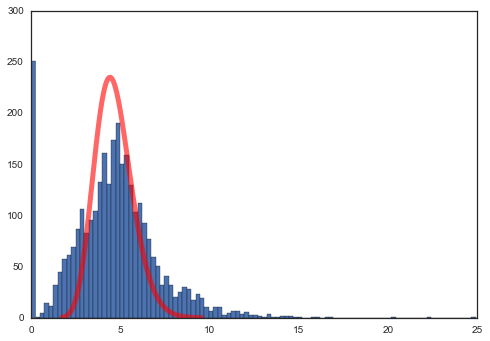

In [4]:
from scipy.stats import gamma
#Put in numpy array
array_data = new_df['aadc'].values
#Get rid of NaN values
array_data = array_data[np.logical_not(np.isnan(array_data))]

#Paramters from BDA
alpha = 20
beta = 430000
inv_beta = 1./beta

#Plot Gamma PDF with arbitrary factor so it is visible with the histogram.  The PDF is in units of rates per 100,000
#See BDA for details.
x = np.linspace(gamma.ppf(0.0001, alpha, scale=inv_beta),
                gamma.ppf(0.9999, alpha, scale=inv_beta), 1000)
plt.hist(array_data, bins=100)
plt.plot(x*100000, gamma.pdf(x, alpha, scale=inv_beta)*0.006,
       'r-', lw=5, alpha=0.6, label='gamma pdf')


With our prior defined, and the knowledge that we are using a Poisson likelihood, we are ready to calculate the posterior.  This is done analytically in BDA and we use MCMC here to show how you can use pymc, which will be helpful in situations with no analytical solution.

In [5]:
#Define a function to take the number of deaths y_j and the population n_j of a county, and the number of samples
#You are encouraged to look at the pymc tutorial to better understand this process
def posterior_theta(y_j, n_j, samples=100000):
    #The prior for the rate parameter
    prior_theta = pm.Gamma("theta", alpha, beta)
    #Likelihood function which incorporates our known data for the county of interest
    likelihood = pm.Poisson("observation", mu=prior_theta*10*n_j, value=y_j, observed=True)
    #Create the Bayesian model for pymc
    mcmc = pm.MCMC([prior_theta, likelihood])
    #Ask pymc to run the sampler, specifying the burn in to be discarded
    mcmc.sample(iter=samples, burn=samples / 4)
    return mcmc

#Test the function on a hypothetical small county with no deaths and a population of 1000
county_1 = [0., 1000.]
test1 = posterior_theta(county_1[0], county_1[1])

 [-----------------100%-----------------] 100000 of 100000 complete in 3.9 sec

Plotting theta


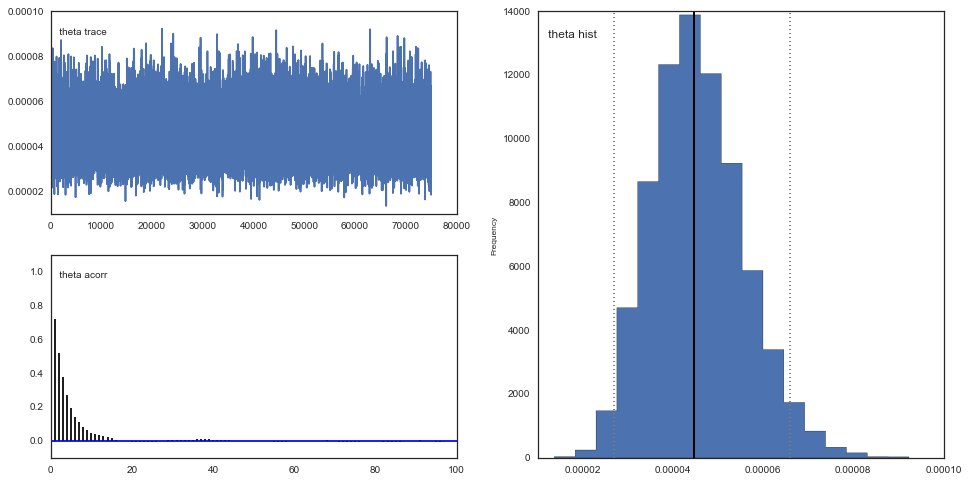

In [6]:
#Examine the sampling procedure
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(test1, new=False)

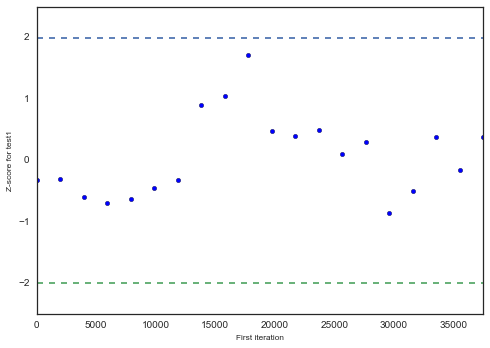

In [7]:
#Check for autocorrelation among samples
geweke_scores = pm.geweke(test1.trace("theta")[:], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "test1")

Estimated rate: 4.55086887782e-05
Analytical rate: 4.55e-05
Estimated standard deviation 1.0205972725e-05
Analytical standard deviation 0.000446320953593


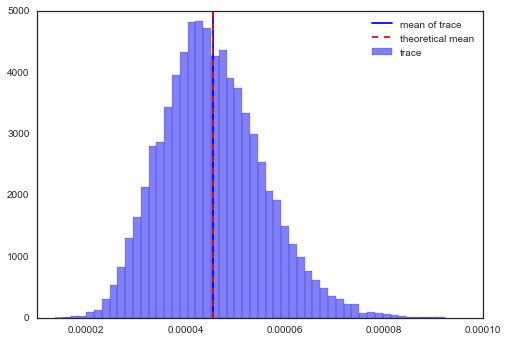

In [8]:
#Plot a histogram of the trace, display the mean value and standard deviation, and compare to analytical values from BDA
test1_trace = test1.trace("theta")[:]

mean_1 = np.mean(test1_trace)
analytical_val = 4.55e-5
print "Estimated rate:", mean_1
print "Analytical rate:", analytical_val

print "Estimated standard deviation", np.std(test1_trace)
print "Analytical standard deviation", np.sqrt( (alpha+county_1[0]) / (alpha + 10*county_1[1])**2 )


hist_h = plt.hist(test1_trace, bins=50, color='blue', alpha=0.5, label='trace')
mean_h = plt.axvline(mean_1, color='blue', label='mean of trace')
analyt_h = plt.axvline(analytical_val, color='red', linestyle = '--', label='theoretical mean')
plt.legend()

### Connection to homework
This confirms pymc is working and we have a realistic way to estimate rates for small counties.  You could use the approach for a hypothetical county of given population and number of deaths.  Think about how things would change for a large county, based on the analytical formula?  This should help you consider your results for Problem 5 on homework 2, except in that case we are talking about upvotes on a Youtube video, and additionally there are considering the effect of different priors.

In general the analytical method we applied will not always be an option.  Also, if we wanted to predict the Bayes-adjusted rate for a county that is actually in our data set, we would not have independent data for our prior.  Hierarchical Bayes solves these issues.


### Hierarchical Bayes
In general, when you're estimating a parameter, and you have quantifiable knowledge of other similar situations, you can use hierarchical Bayesian modeling to incorporate this information.  The similar situations are called exchangeable units and for our example, the exchangable unit a county.  We can then characterize the joint probability distribution for the parameters for the Gamma distribution along with the Bayesian probability model.  This is detailed in Chapter 5 of BDA and will be discussed in class soon.